# Importing Necessary Libraries

In [131]:
import warnings
warnings.simplefilter('ignore')

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

In [133]:
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

In [134]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from collections import defaultdict

# Project Overview

In [135]:
# Building Popularity Recommender model
# -----------------------------------------------------------------------------------------------------
# (i) Popularity Recommender Model Based on highest score (Maximum Purchased, Average Rating is not considered)
# (ii) Popularity Recommender Model Based on Maximum Average Rating (Purchased count is not considered)
# (iii) Popularity Recommender Model Based on Maximum Average Rating and Mostly Purchased
# Suggested the top 5 products under each category
# ------------------------------------------------------------------------------------------------------
# Building Collaborative Filtering model (Based on the Customer Habits)
# ------------------------------------------------------------------------------------------------------
# (i) Model-based Collaborative Filtering: Singular Value Decomposition (Without Surprise Package)
# (ii) User-based Collaborative Filtering (Using Surprise Package),  Algorithm used - KNNWithMeans
# (iii) User-based Collaborative Filtering (Using Surprise Package),  Algorithm used - SVD
# Finally calculated RMSE and MAE for the collaberative filtering model and suggested the top 5 products for each users.

# 1. Read and explore the given dataset. 
(Rename column / add headers, plot histograms, find data characteristics)

In [136]:
ratings_df=pd.read_csv('ratings_Electronics.csv', header= None, sep=',')
ratings_df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [137]:
# Shape of the data
print(" Shape of the data is", ratings_df.shape)
print(" Total Number of ratings available", len(ratings_df))

 Shape of the data is (7824482, 4)
 Total Number of ratings available 7824482


In [138]:
# Adding headers to the dataframe 
ratings_df.columns = ['User_Id', 'Product_Id', 'Rating', 'Timestamp']
ratings_df.head()

,User_Id,Product_Id,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [139]:
#Checking Data types
ratings_df.dtypes

User_Id        object
Product_Id     object
Rating        float64
Timestamp       int64
dtype: object

In [140]:
# Check for missing values present
print('Number of missing values across columns-\n', ratings_df.isnull().sum())

Number of missing values across columns-
 User_Id       0
Product_Id    0
Rating        0
Timestamp     0
dtype: int64


In [141]:
# There is no missing values in the given dataset i.e all the given ratings 7824482 have any missing values

In [142]:
# Dropping down time stamp since it is not necessary
ratings_df.drop(['Timestamp'],axis=1, inplace=True) 
ratings_df.head()

,User_Id,Product_Id,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [143]:
# 5 point Summary (including categorical datatypes)
print('5 Point Summary of Original dataset (including categorical datatypes)')
ratings_df.describe(include='all').T

5 Point Summary of Original dataset (including categorical datatypes)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
User_Id,7824482,4201696,A5JLAU2ARJ0BO,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Id,7824482,476002,B0074BW614,18244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,7.82448e+06,NaN,NaN,NaN,4.01234,1.38091,1,3,5,5,5


Number of unique users in the given data =  4201696
Top 20 Users who had given Maximum Ratings
User_Id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
dtype: int64


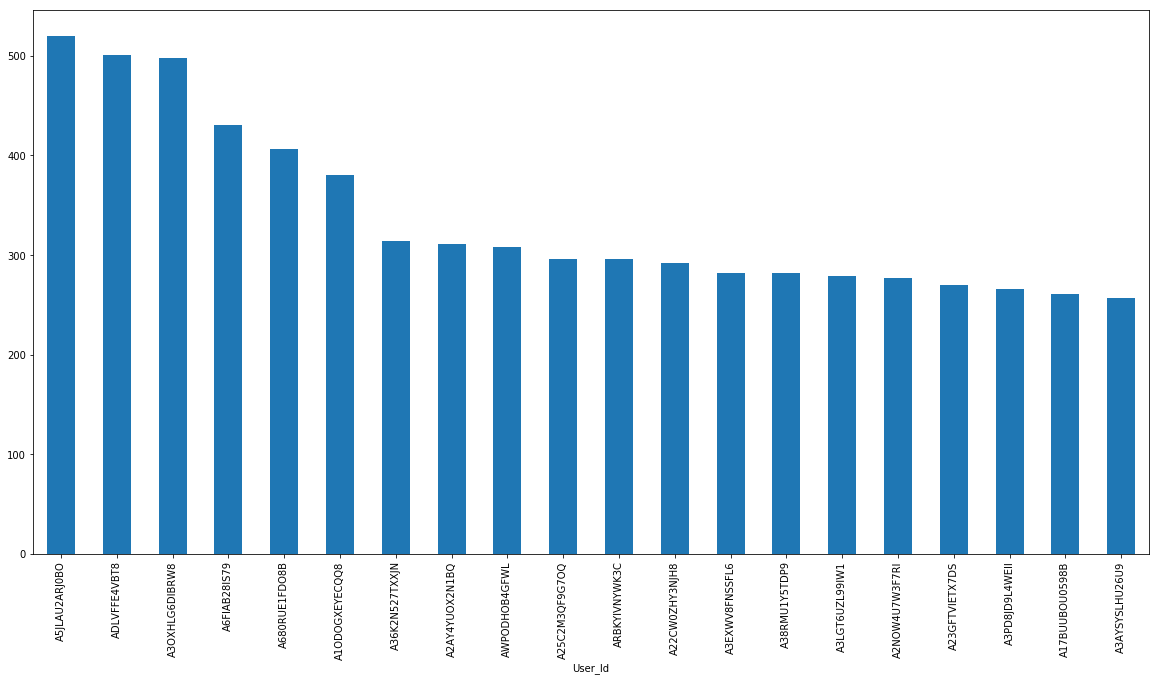

In [144]:
# Number of unique user id and product id in the data
print('Number of unique users in the given data = ', ratings_df['User_Id'].nunique())
# Top 20 users based on rating
most_rated_user = ratings_df.groupby('User_Id').size().sort_values(ascending=False)[:20]
print('Top 20 Users who had given Maximum Ratings')
print(most_rated_user)
# Plotting down the top 20 rated users 
plt.figure(figsize=(20,10))
most_rated_user.plot('bar')

Number of unique products in the given data =  476002
Top 20 rated products
Product_Id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
B008OHNZI0     8966
B003LR7ME6     8840
B000LRMS66     8715
B009SYZ8OC     8370
B00BGA9WK2     7561
B004QK7HI8     7060
B009A5204K     7059
B00BGGDVOO     6893
B0098F5W0Q     6616
B002MAPRYU     6599
dtype: int64


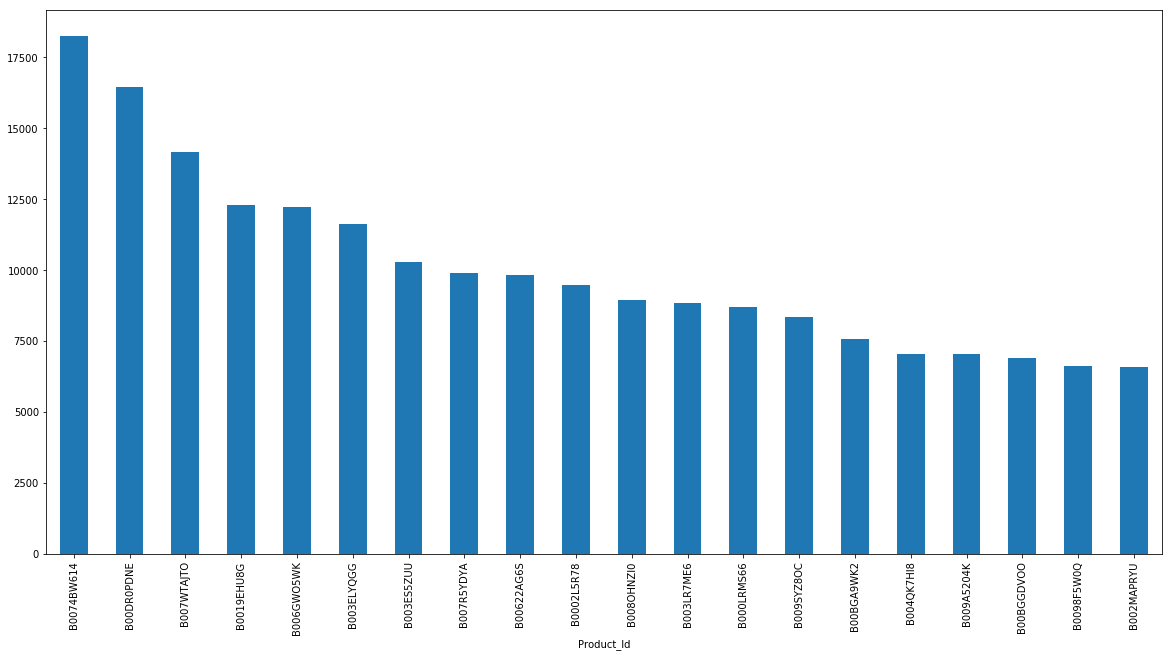

In [145]:
print('Number of unique products in the given data = ', ratings_df['Product_Id'].nunique())
# Top 20 rated products
most_rated_products = ratings_df.groupby('Product_Id').size().sort_values(ascending=False)[:20]
print('Top 20 rated products')
print(most_rated_products)
# Plotting down the top 20 rated users 
plt.figure(figsize=(20,10))
most_rated_products.plot('bar')

In [146]:
# Observing the unique values under the rating column
print('The unique ratings are', ratings_df['Rating'].unique())
# find minimum and maximum ratings
print('The minimum rating is: %d' %(ratings_df['Rating'].min()))
print('The maximum rating is: %d' %(ratings_df['Rating'].max()))

The unique ratings are [5. 1. 3. 2. 4.]
The minimum rating is: 1
The maximum rating is: 5


The total number of counts under each ratings are


5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Rating, dtype: int64

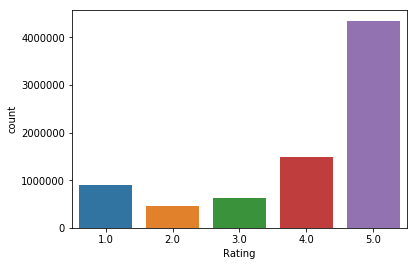

In [147]:
# Plotting down the number of ratings and its equivalent count values
sns.countplot(ratings_df['Rating'])
print('The total number of counts under each ratings are')
ratings_df['Rating'].value_counts()

In [148]:
# Summary statistics of 'Rating' variable
ratings_df['Rating'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [149]:
# Analysing the attribute 'Rating'
print("mean   : ", np.mean(ratings_df['Rating']))
print("median : ", np.median(ratings_df['Rating']))
print("var    : ", np.var(ratings_df['Rating']))
print("std    : ", np.std(ratings_df['Rating']))

mean   :  4.012336791112817
median :  5.0
var    :  1.9069116832072701
std    :  1.3809097302891562


In [150]:
# Inference after Exploratory Data Analysis
# ------------------------------------------------------------------------------------------
# Total no.of ratings available in the given dataset is --> 7,82,44,824
# No. of Unique Users in the given dataset              -->   42,01,696
# No. of Unique Products in the given dataset           -->    4,76,002
# Ratings provided by the users are on scale of 1-5 scale
# Most of the users (43,47,541 ) were satisfied with the products purchased and rated 5.0

# 2. Take a subset of the dataset to make it less sparse/ denser.
( For example, keep the users only who has given 50 or more number of ratings ) 

In [151]:
# Making the datset into less sparse/denser by considering the users who have rated atleast 50 ratings

In [152]:
max_rated_user=pd.DataFrame(ratings_df['User_Id'].value_counts()) # Counting the no. of ratings provided by each user in the data set
new_user= max_rated_user[(max_rated_user['User_Id']>=50)].loc[:,['User_Id']] # Filtering the user who had given atleast 50 ratings
new_user.columns = ['No. of Ratings Provided by the users'] # Setting the column header
new_user # Displaying the finalized Users

,No. of Ratings Provided by the users
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308
A25C2M3QF9G7OQ,296


In [153]:
# Selecting the users who had given atleast 50 ratings and dropping down the other users from the given dataset
subset_user=new_user.index 
new_ratings_df=ratings_df[ratings_df['User_Id'].isin(subset_user)]
new_ratings_df # Finalized Dataset
# new_ratings_df has users who have rated 50 or more items

,User_Id,Product_Id,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1003,A2Y4H3PXB07WQI,0972683275,4.0
1138,A25RTRAPQAJBDJ,0972683275,5.0
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0


In [154]:
new_ratings_df = new_ratings_df.reset_index() # Resetting Index
new_ratings_df.drop('index',axis=1,inplace=True) 
new_ratings_df.head()

,User_Id,Product_Id,Rating
0,A3BY5KCNQZXV5U,0594451647,5.0
1,AT09WGFUM934H,0594481813,3.0
2,A32HSNCNPRUMTR,0970407998,1.0
3,A17HMM1M7T9PJ1,0970407998,4.0
4,A3CLWR1UUZT6TG,0972683275,5.0


In [155]:
print('Number of unique users in the finalized dataset = ', new_ratings_df['User_Id'].nunique())
print('Number of unique products in the finalized dataset = ', new_ratings_df['Product_Id'].nunique())
print('Total Number of ratings in the finalized dataset =', len(new_ratings_df))

Number of unique users in the finalized dataset =  1540
Number of unique products in the finalized dataset =  48190
Total Number of ratings in the finalized dataset = 125871


In [156]:
# Summary statistics of 'Rating' variable for the less sparse dataset
new_ratings_df['Rating'].describe().transpose()

count    125871.000000
mean          4.261339
std           1.062144
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [157]:
# Observing the unique values under the rating column
print('The unique ratings are', new_ratings_df['Rating'].unique())

# find minimum and maximum ratings
print('The minimum rating is: %d' %(new_ratings_df['Rating'].min()))
print('The maximum rating is: %d' %(new_ratings_df['Rating'].max()))

The unique ratings are [5. 3. 1. 4. 2.]
The minimum rating is: 1
The maximum rating is: 5


The total number of counts under each ratings are


5.0    71034
4.0    32295
3.0    12060
2.0     5367
1.0     5115
Name: Rating, dtype: int64

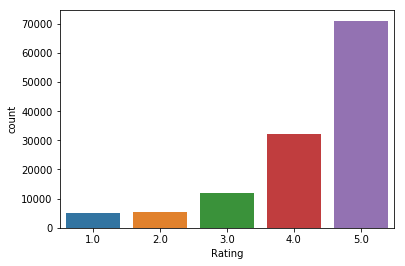

In [158]:
# Plotting down the number of ratings and its equivalent count values
sns.countplot(new_ratings_df['Rating'])
print('The total number of counts under each ratings are')
new_ratings_df['Rating'].value_counts()

In [159]:
# Inference: Most of the product got maximum ratings

In [160]:
# In the less sparse/ denser dataset (new_ratings_df)
# ------------------------------------------------------------------------------------------
# Total no.of ratings    --> 1,25,871
# No. of Unique Users    -->    1,540
# No. of Unique Products -->   48,190
# Most of the users (71,034/ 1,25,871) were satisfied with the products purchased and rated 5.0

In [161]:
# Comparing the original Dataset and Subset of Original Dataset
# ---------------------------------------------------------------------------------------------
#                                    Original Dataset               Subset of Original Dataset
#                                     (ratings_df)                     (new_ratings_df)
# ----------------------------------------------------------------------------------------------
# Total no.of ratings                  7,82,44,824                        1,25,871
# No. of Unique Users                    42,01,696                           1,540
# No. of Unique Products                  4,76,002                          48,190
# ---------------------------------------------------------------------------------------------

In [162]:
# Generating the rating Matrix
final_ratings_matrix = new_ratings_df.pivot(index = 'User_Id', columns ='Product_Id', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

# Calculating the density of the rating matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [163]:
# Density of the ratings matrix in very less.

In [164]:
final_ratings_matrix

Product_Id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User_Id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10H24TDLK2VDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
# The dataframe "new_ratings_df" contains 1540 unique users and 48190 unique products.

# 3. Split the data randomly into train and test dataset.
( For example, split it in 70/30 ratio)

In [166]:
train_data, test_data = train_test_split(new_ratings_df, test_size = 0.3, random_state=0)
train_data.head()

,User_Id,Product_Id,Rating
103386,A2BYV7S1QP2YIG,B009EAHVTA,5.0
78138,AB094YABX21WQ,B0056XCEAA,1.0
70422,A3D0UM4ZD2CMAW,B004I763AW,5.0
63841,AATWFX0ZZSE6C,B0040NPHMO,3.0
31241,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [167]:
print(train_data.shape) # 70% of 1285871 = 88109.7
print(test_data.shape)  # 30% of 1285871 = 37761.3

(88109, 3)
(37762, 3)


# 4. Build Popularity Recommender model. (Non-personalised)

(i) Building Popularity Recommender model - Based on Maximum no. of Rating given by the users

(ii)  Building Popularity Recommender model - Based on Highest  Average Rating

(iii) Building Popularity Recommender model - Based on Maximum purchased with Highest Average Rating

### 4. (i) Building Popularity Recommender model - Based on Maximum no. of Rating given by the users

 * In this the ratings are not considered.

 * Most frequently brought products were considered as the Popular products

In [168]:
# Recommendation score is calculated by counting the no.of ratings given by users for each products 
train_data_grouped = train_data.groupby('Product_Id').agg({'User_Id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'User_Id': 'score'},inplace=True)
train_data_grouped.head()

,Product_Id,score
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [169]:
#Sorting the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'Product_Id'], ascending = [0,1]) 
      
#Generating a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,Product_Id,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [170]:
# Function Definition -- using popularity based recommender model to make predictions

def recommend(n,user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [171]:
# Recommendening using Popularity based recommender model on the test data

n=input("Enter the total no.of user for popularity recommendation ")
print('\n')
x=test_data['User_Id'].values.tolist()
y=list(range(1, len(x)+1))
for i in range(int(n)):
    User_Number = input("Enter the user number ")
    print ("The user id is " , x[int(User_Number)-1])
    user_id=x[int(User_Number)-1]
    print("Here is the recommendation for the userId: " , (x[int(User_Number)-1]))
    print(recommend(i,user_id)) 
    print('\n')

Enter the total no.of user for popularity recommendation 5


Enter the user number 10
The user id is  A3D6OI36USYOU1
Here is the recommendation for the userId:  A3D6OI36USYOU1
               userID  Product_Id  score  Rank
30847  A3D6OI36USYOU1  B0088CJT4U    133   1.0
30287  A3D6OI36USYOU1  B007WTAJTO    124   2.0
19647  A3D6OI36USYOU1  B003ES5ZUU    122   3.0
8752   A3D6OI36USYOU1  B000N99BBC    114   4.0
30555  A3D6OI36USYOU1  B00829THK0     97   5.0


Enter the user number 50
The user id is  A2T3S3VTW65VO5
Here is the recommendation for the userId:  A2T3S3VTW65VO5
               userID  Product_Id  score  Rank
30847  A2T3S3VTW65VO5  B0088CJT4U    133   1.0
30287  A2T3S3VTW65VO5  B007WTAJTO    124   2.0
19647  A2T3S3VTW65VO5  B003ES5ZUU    122   3.0
8752   A2T3S3VTW65VO5  B000N99BBC    114   4.0
30555  A2T3S3VTW65VO5  B00829THK0     97   5.0


Enter the user number 100
The user id is  A3077MQTAKOVFZ
Here is the recommendation for the userId:  A3077MQTAKOVFZ
               userID  Pr

In [172]:
# Inference
# ---------------------------------------------------------------------------------------
# The popularity based Recommendation system recommends the same product to all the users
# It is not a personalised one

In [173]:
# Calculating the Average rating for the popularity based recommended model
s1 = train_data.groupby('Product_Id')['Rating'].count()
s2 = train_data.groupby('Product_Id')['Rating'].mean()
combined_df = pd.DataFrame(dict(s1 = s1, s2 = s2))
combined_df.columns = ['score', 'Average Rating']
#Sorting the products on recommendation score 
combined_df = combined_df.sort_values(['score', 'Product_Id'], ascending = [0,1])
combined_df.head()

,score,Average Rating
Product_Id,,
B0088CJT4U,133,4.187970
B007WTAJTO,124,4.637097
B003ES5ZUU,122,4.844262
B000N99BBC,114,4.763158
B00829THK0,97,4.474227


In [174]:
s1=train_data.groupby('Product_Id')['Rating'].mean()
df = pd.DataFrame(dict(s1 = s1))
df.columns = ['Average Rating']
df = df.sort_values(['Average Rating', 'Product_Id'], ascending = [0,1])
df.head()

,Average Rating
Product_Id,
0594451647,5.0
0972683275,5.0
1400532620,5.0
1400698987,5.0
1685560148,5.0


In [175]:
# Observation:
# ------------
# While comparing the recommended products (having highest score) with the products with highest ratings there is a mismatch.
# i.e the recommended product doesn't have the highest score.
# So trying to build a popularity based recommended model based on highest rating

### 4. (ii)  Building Popularity Recommender model - Based on Highest  Average Rating


* The product with maximum Average rating are considered as popular products

* Not considering the no. of times the item was purchased

In [176]:
ratings_mean_count=pd.DataFrame(train_data.groupby('Product_Id')['Rating'].mean())
ratings_mean_count.columns = ['Average Rating']
ratings_mean_count.sort_values("Average Rating", axis = 0, ascending = False, inplace=True) 
ratings_mean_count

,Average Rating
Product_Id,
0594451647,5.0
B001H4B0AC,5.0
B001H318NC,5.0
B001H318M8,5.0
B006FO094M,5.0
B001H1CD92,5.0
B001H0GI9Y,5.0
B001H0GEW0,5.0
B006G0EM84,5.0


In [177]:
# More no. of products have the rating 5
# Counting down the no.of products having the maximum average rating
ratings_mean_count['Average Rating'].value_counts().sort_index(ascending=False)

5.000000    17311
4.967742        1
4.952381        1
4.944444        2
4.941176        2
4.935484        1
4.928571        2
4.923077        2
4.920000        1
4.916667        5
4.913043        1
4.909091       12
4.903846        1
4.900000       13
4.894737        1
4.888889       16
4.884615        1
4.875000       29
4.869565        1
4.866667        4
4.862069        1
4.857143       50
4.853333        1
4.850000        2
4.846154       11
4.844262        1
4.842105        1
4.838710        2
4.833333       84
4.830189        1
            ...  
2.800000       11
2.750000       27
2.714286        3
2.700000        1
2.666667       45
2.636364        1
2.625000        3
2.600000        4
2.571429        4
2.555556        3
2.500000      165
2.428571        2
2.400000        1
2.333333       38
2.266667        1
2.250000        5
2.200000        2
2.166667        1
2.142857        1
2.125000        1
2.000000     1320
1.833333        1
1.750000        2
1.666667        6
1.600000  

In [178]:
# Observing the products having '5 ratings'
# -----------------------------------------
# 17311 products have '5 ratings'

In [179]:
Popularity_recommendation=ratings_mean_count[(ratings_mean_count['Average Rating']==5)] 
Popularity_recommendation

,Average Rating
Product_Id,
0594451647,5.0
B001H4B0AC,5.0
B001H318NC,5.0
B001H318M8,5.0
B006FO094M,5.0
B001H1CD92,5.0
B001H0GI9Y,5.0
B001H0GEW0,5.0
B006G0EM84,5.0


In [180]:
# Inference:
# ----------
# Totally - 17311 items have '5 ratings'
# Obviously all the items cannot be recommended to a each users
# Now Observing the score value for the products having '5 ratings'.

In [181]:
# Now Observing the score value for the products having '5 ratings'.
ratings_mean_count['score']=pd.DataFrame(train_data.groupby('Product_Id')['Rating'].count())
ratings_mean_count.sort_values("Average Rating", axis = 0, ascending = False, inplace=True) 
Popularity_recommendation=ratings_mean_count 
Popularity_recommendation=ratings_mean_count[(ratings_mean_count['Average Rating']==5)] 
Popularity_recommendation

,Average Rating,score
Product_Id,,
0594451647,5.0,1
B00030F7I2,5.0,1
B00CX8BVC8,5.0,1
B00CX8OT8Q,5.0,1
B0002ZQHFA,5.0,1
B00CXACPN0,5.0,4
B0002ZPP2G,5.0,1
B000309ZA8,5.0,1
B00CWYRA8W,5.0,1


In [182]:
Popularity_recommendation['score'].max()

14

In [183]:
Popularity_recommendation['score'].value_counts().sort_index(ascending=False)

14        3
13        3
12        3
11        5
10        6
9        14
8        21
7        30
6        65
5       109
4       229
3       565
2      1954
1     14304
Name: score, dtype: int64

In [184]:
# Inference:
# ----------
# The '5 rated' products were purchase by less no. of users

In [185]:
# Inference:
# ----------
# Most of the the products were purchased very rarely and rated '5' (only once)
# So this is not a better way of popularity recommendations

### 4. (iii) Building Popularity Recommender model - Based on Maximum purchased with Highest Average Rating


* The Maximum purchased product with maximum Average rating is considered.

In [186]:
Popularity_recommendation.sort_values("score", axis = 0, ascending = False, inplace=True) 
Popularity_recommendation

,Average Rating,score
Product_Id,,
B0036AWR8E,5.0,14
B000F7QRTG,5.0,14
B000FQ2JLW,5.0,14
B00HG1L334,5.0,13
B00081A2KY,5.0,13
B0033PRWSW,5.0,13
B0002D6QJO,5.0,12
B00HZWJGS8,5.0,12
B000Q82PIQ,5.0,12


In [187]:
# Considering the products having the rating count of atleast 80 values
well_rated_filter=ratings_mean_count.apply(lambda x: x['score']>80, axis='columns')
well_rated_df=ratings_mean_count[well_rated_filter]
well_rated_df.head()

,Average Rating,score
Product_Id,,
B003ES5ZUU,4.844262,122
B000N99BBC,4.763158,114
B004CLYEDC,4.658537,82
B007WTAJTO,4.637097,124
B00829THK0,4.474227,97


In [188]:
popularity_recommendations=well_rated_df.head()
popularity_recommendations

,Average Rating,score
Product_Id,,
B003ES5ZUU,4.844262,122
B000N99BBC,4.763158,114
B004CLYEDC,4.658537,82
B007WTAJTO,4.637097,124
B00829THK0,4.474227,97


In [189]:
n=input("Enter the total no.of user for popularity recommendation ")
print('\n')
x=test_data['User_Id'].values.tolist()
y=list(range(1, len(x)+1))
for i in range(int(n)):
    User_Number = input("Enter the user number ")
    print ("The user id is " , x[int(User_Number)-1])
    user_id=x[int(User_Number)-1]
    print("Here is the recommendation for the userId: " , (x[int(User_Number)-1]))
    print(recommend(i,user_id)) 
    print('\n')

Enter the total no.of user for popularity recommendation 5


Enter the user number 10
The user id is  A3D6OI36USYOU1
Here is the recommendation for the userId:  A3D6OI36USYOU1
                    userID  Average Rating  score
Product_Id                                       
B003ES5ZUU  A3D6OI36USYOU1        4.844262    122
B000N99BBC  A3D6OI36USYOU1        4.763158    114
B004CLYEDC  A3D6OI36USYOU1        4.658537     82
B007WTAJTO  A3D6OI36USYOU1        4.637097    124
B00829THK0  A3D6OI36USYOU1        4.474227     97


Enter the user number 50
The user id is  A2T3S3VTW65VO5
Here is the recommendation for the userId:  A2T3S3VTW65VO5
                    userID  Average Rating  score
Product_Id                                       
B003ES5ZUU  A2T3S3VTW65VO5        4.844262    122
B000N99BBC  A2T3S3VTW65VO5        4.763158    114
B004CLYEDC  A2T3S3VTW65VO5        4.658537     82
B007WTAJTO  A2T3S3VTW65VO5        4.637097    124
B00829THK0  A2T3S3VTW65VO5        4.474227     97


Enter

In [67]:
# Inference:
# ---------
# By using this popularity based recommender model maximum purchased products with maximum average rating can be recommended.

In [68]:
# Drawback of Popularity Based Recommendation Model
# -------------------------------------------------
# It is not a personalised one.
# All users in the training set are recommended with the same products recommendations

# 5. Build Collaborative Filtering Model

(i) Model-based Collaborative Filtering: Singular Value Decomposition (Without Surprise Package)

(ii)  User-based Collaborative Filtering (Using Surprise Package),  Algorithm used - KNNWithMeans

(iii) User-based Collaborative Filtering (Using Surprise Package),  Algorithm used - SVD

###  (i) Model-based Collaborative Filtering: Singular Value Decomposition (Without using Surprise Package)

# 5.  (i) Build Collaborative Filtering model.


In [207]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,User_Id,Product_Id,Rating
0,103386,A2BYV7S1QP2YIG,B009EAHVTA,5.0
1,78138,AB094YABX21WQ,B0056XCEAA,1.0
2,70422,A3D0UM4ZD2CMAW,B004I763AW,5.0
3,63841,AATWFX0ZZSE6C,B0040NPHMO,3.0
4,31241,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [208]:
# User-based Collaborative Filtering
# Matrix with 'Users' in the rows' and 'Items' in the column 
pivot_df = df_CF.pivot(index = 'User_Id', columns ='Product_Id', values = 'Rating').fillna(0)
pivot_df.shape

(1540, 48190)

In [209]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

Product_Id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
User_Id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [210]:
User_Id=pivot_df.index.tolist()

In [211]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

Product_Id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
# Applying Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Constructing diagonal array in SVD
sigma = np.diag(sigma)

In [213]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

Product_Id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


###  (i) Model-based Collaborative Filtering: Singular Value Decomposition (Without using Surprise Package)
# 6. (i) Evaluate both the models. 
(Comparing Actual and Predicted values)

Evaluation of Model-based Collaborative Filtering (SVD)

In [214]:
# Actual ratings given by the users
final_ratings_matrix.head()

Product_Id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User_Id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

Product_Id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [216]:
# Predicted ratings 
preds_df.head()

Product_Id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [217]:
# Average PREDICTED rating for each item
preds_df.mean().head()

Product_Id
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [218]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
Product_Id,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [219]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



In [220]:
MAE=round((abs(rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings)).mean(), 5)
print('\n RAE SVD Model = {} \n'.format(MAE))


 RAE SVD Model = 0.00224 



###  (i) Model-based Collaborative Filtering: Singular Value Decomposition (Without using Surprise Package)
# 7. (i) Get top - K ( K = 5) recommendations. 
Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new product

In [221]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    final_temp = temp.head(num_recommendations)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(final_temp)

In [222]:
# Recommendening using Popularity based recommender model on the test data
y=list(range(1,len(User_Id)+1))
n=input("Enter the total no.of user for User Based Recommendations ")
print('\n')
num_recommendations=5
for i in range(int(n)):
    User_Number = input("Enter the user number ")
    print ("The user id is " , User_Id[int(User_Number)-1])
    print("Here is the recommendation for the userId: " , (User_Id[int(User_Number)-1]))
    print(recommend_items(int(User_Number),pivot_df,preds_df,num_recommendations)) 
    print('\n')

Enter the total no.of user for User Based Recommendations 5


Enter the user number 10
The user id is  A10X9ME6R66JDX
Here is the recommendation for the userId:  A10X9ME6R66JDX

Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          1.594319
B003ES5ZUU                  0.0          1.333773
B001TH7GUU                  0.0          0.878497
B000QUUFRW                  0.0          0.722314
B002WE6D44                  0.0          0.718801
None


Enter the user number 50
The user id is  A141R97FHSSUQ0
Here is the recommendation for the userId:  A141R97FHSSUQ0

Below are the recommended items for user(user_id = 50):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.663672
B00829TIEK                  0.0          1.272065
B002R5AM7C                  0.0    

In [206]:
# Inference:
# ---------
# Different sets of products were recommended to different users.
# Recommended the products which were not purchased already by the users

###  (ii) User-based Collaborative Filtering (Using Surprise Package).  Algorithm used is KNNWithMeans
# 5. (ii) Build Collaborative Filtering model.


In [223]:
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(new_ratings_df[['User_Id', 'Product_Id', 'Rating']], reader)

In [224]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30)

In [225]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [226]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [227]:
test_pred

[Prediction(uid='AO2EURP2Y4JZM', iid='B00IVPU59W', r_ui=5.0, est=4.116279069767442, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AFM2J3HJNPIHV', iid='B0040PZ3EE', r_ui=4.0, est=4.262981080252868, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A23GFTVIETX7DS', iid='B003X26LXW', r_ui=4.0, est=3.620857264061816, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A2Q204DY2L7YRP', iid='B009CQKGSO', r_ui=4.0, est=4.262981080252868, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1TDR7Y90SVCHL', iid='B0064Z71T8', r_ui=1.0, est=4.433333333333334, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3OXHLG6DIBRW8', iid='B00516547C', r_ui=5.0, est=4.262981080252868, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AYOMAHLWRQHUG', iid='B007F9XHAY', r_ui=5.0, est=4.262981080252868, details={'was_impossible': 

###  (ii) User-based Collaborative Filtering (Using Surprise Package).  Algorithm used is KNNWithMeans
# 6. (ii) Evaluate both the models. 
(Comparing testing_data with predicted data)

In [228]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0534


1.0534102525768172

In [229]:
# get MAE
print("User-based Model : Test Set")
accuracy.mae(test_pred, verbose=True)

User-based Model : Test Set
MAE:  0.7760


0.7759775402723187

###  (ii) User-based Collaborative Filtering (Using Surprise Package).  Algorithm used is KNNWithMeans
# 7. (ii) Get top - K ( K = 5) recommendations. 
Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products.

In [230]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [231]:
top_n = get_top_n(test_pred, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

AO2EURP2Y4JZM ['B00DCY0O3E', 'B001CIREXA', 'B005IA844Q', 'B00511PS3C', 'B0042FZ50O']
AFM2J3HJNPIHV ['B007WTAJTO', 'B00006RVPW', 'B0040PZ3EE', 'B004D4G5RG', 'B00350GKQ0']
A23GFTVIETX7DS ['B00CMJZAOI', 'B000NB05MO', 'B00BN2AJOQ', 'B000TKHBDK', 'B00G4UQ6U8']
A2Q204DY2L7YRP ['B003Y30334', 'B002IO2UM2', 'B007WTAJTO', 'B003ZKG10K', 'B004BFZHO4']
A1TDR7Y90SVCHL ['B001K7I62Q', 'B00006JN3G', 'B004KABG22', 'B001E1Y5O6', 'B000F9YN22']
A3OXHLG6DIBRW8 ['B004JMZPJQ', 'B000V9T2JA', 'B0012X5766', 'B002GTAUT4', 'B007F9XHBI']
AYOMAHLWRQHUG ['B001OC6DCW', 'B004HW7KDC', 'B00BEHQKPC', 'B003STVG80', 'B00DQZSIW8']
A2SH6A32BE6NEV ['B00EOI2SYK', 'B00EU9V3YO', 'B00EOI2TD0', 'B0081FLFQE', 'B004CLYEDC']
A3ER6ARJ23CIN8 ['B003UE52ME', 'B001E1Y5O6', 'B003JL7XFM', 'B003LVZO8S', 'B004HKIB6E']
A2HXE29CU1I24Y ['B000J6CDL4', 'B000TQU352', 'B0031U1AU0', 'B000063WPY', 'B000068IH6']
A1F7YU6O5RU432 ['B00BGA9WK2', 'B00BQ8R76K', 'B00BB6DCUC', 'B00746W3HG', 'B007W7PIZ6']
A2U3OEIK1CUPIK ['B000CS1TLE', 'B0013HHDH2', 'B002BH4MWW',

A2HJY7418G1KV1 ['B007XJGZLE', 'B004QC1EOO', 'B002IPMQTS', 'B005EVPZJQ', 'B004E55OGC']
AD8DLOGHAXL ['B000051299', 'B000VX6XL6', 'B0054FCQUS', 'B003O8J11O', 'B003FG579K']
AXP8GO5Q3AXSA ['B0093H4WT6', 'B000204SWE', 'B00AE0IEHM', 'B00834SJSK', 'B005CLPP84']
A17W0GMB0YY83M ['B003XM73P2', 'B005PSTV2K', 'B00276D4RG', 'B0076NA716', 'B005DTBCD2']
A141R97FHSSUQ0 ['B00AJHDZSI', 'B003YKG2XM', 'B004QGXOOI', 'B00GRNUO2I', 'B00AR95ESC']
A35KBAQ4VBNQ6L ['B0051XDOZO', 'B000P910OG', 'B0026FCAYG', 'B00BWV53UI', 'B0002MQGK4']
AEN44U6T9R93 ['B00419YR3C', 'B000PAMF44', 'B0000AE6AN', 'B005OIGWTG', 'B008RNZIMW']
A3TAS1AG6FMBQW ['B00EQD5ZS4', 'B00IVPU6AA', 'B005CLMJLU', 'B001542X64', 'B000S5Q9CA']
A3PDWA32BAMB2Y ['B000QUUFRW', 'B004RORMF6', 'B00H3EF18C', 'B004LNWMA8', 'B00E5T5BJW']
ASFW4ZMNZJKDA ['B003Q9AZHU', 'B00CI3BIWQ', 'B00E7LSCNK', 'B00752R4S2', 'B00E3VLB28']
A2NSMJVQY0RV9S ['B000NP3DJW', 'B00316263Y', 'B000NP46K2', 'B002V88HFE', 'B004TJ6JH6']
A3L1VJMHFWONCB ['B00F6E4HXG', 'B0002MQGOA', 'B00E3W15P0', 'B0

A186697K4XKXQL ['B0058GK55Q', 'B001BM5XB2', 'B003YTROIU', 'B009Z7KMUM', 'B004ZKH1NA']
A3GVXKCTFN3YDN ['B00BOHNYU6', 'B00829TIA4', 'B002VPE21A', 'B001TOD7ME', 'B00BOHNYTW']
A8P6GIIQ6YQV8 ['B002VM4D76', 'B005HEEF1Y', 'B00JF69JT8', 'B00HCPX4CM', 'B0051QHPJM']
AQ55H30MZSV0Q ['B000I6F0TC', 'B006O70ZR6', 'B00000J3H5', 'B00AAZOBSC', 'B000J5LA9Q']
A34C9AFFZOI45T ['B004KN7PZG', 'B0016RNX2I', 'B000SA7I0M', 'B001OORMVQ', 'B002B8WVVU']
A1ITRGMT80D5TK ['B0056H9KKI', 'B00KJJW36G', 'B0050M92CU', 'B0016PCPNS', 'B0057X4TWA']
AFHYEO3Y1IIDD ['B001B077PO', 'B002TLTE7I', 'B008MF3X9K', 'B00475XLOG', 'B000F8FNSG']
A35Q0RBM3YNQNF ['B009AOFKUM', 'B00884WH74', 'B0035FZ14M', 'B009A68TMQ', 'B006LVZDSQ']
A185O1MX1RP964 ['B000067RT6', 'B000EUFJXE', 'B005IGVY6K', 'B00355IJU0', 'B000LRMS66']
A2ZFBTGPDP6PH6 ['B000QUUFRW', 'B001LF40WW', 'B004TGQBRW', 'B0083EPC80', 'B001DDLU1Q']
A32482Z7XIKDQX ['B000Y138EK', 'B008N06I2I', 'B00FB45SI4', 'B006QB1RPY', 'B002UT42UI']
ACH055GTTIGC9 ['B0001HA8WW', 'B001DJHEVU', 'B003ZHTNNK', 

A3TBMAWIIHKHFN ['B00009UHCI', 'B004TJ6JH6', 'B003U6Y1OC', 'B005YQY5TM', 'B000MVBHRW']
A2Y4H3PXB07WQI ['B004E9SAUU', 'B00CD8ADKO', 'B000EPRG6W', 'B009FUF6DM', 'B005Y8BYOE']
AHQRU3MRORIWQ ['B008EQYRRY', 'B000N99BBC', 'B0054JE70G', 'B004Q3R9B0', 'B004CLYEB4']
A3CJ7MHAS9IMAM ['B000V5P90K', 'B001FA1NZK', 'B001CCAISE', 'B0088CJT4U', 'B005DOK8NW']
A3MU9G6YWKTGTA ['B000ZD0CV4', 'B001E2V7R8', 'B001V9LPT4', 'B000LB7G00', 'B00007M1TZ']
AS7J4952JB5XR ['B005TCMW7S', 'B00BAEJWIG', 'B00592005E', 'B005UGQTOK', 'B007O2VQNC']
AO09RWV40IX78 ['B00F1CRTLK', 'B00EL8NII8', 'B00DQZQCUI', 'B00E6ONJJU', 'B007Q8GOGI']
A1JZFGZEZVWQPY ['B00BWX2OU8', 'B007X3VC7W', 'B000N99BBC', 'B00L1NZTSS', 'B0009RJNJ8']
A26SO3TOT2TLJE ['B00EH5UGR6', 'B00ATM1MHO', 'B002LLK5CO', 'B005TDWVTQ', 'B003LSTD38']
A1KKE6VX8VPWZK ['B007ZZ6OW6', 'B00829TIEK', 'B00829TIA4', 'B001TUYTZM', 'B0015AARJI']
A1HSM98KUGTHNY ['B005H2BRGC', 'B001GKLMH8', 'B001RC3WD2', 'B001O0KWMG', 'B0002DDZ66']
A2DIQTZPF26T1L ['B00BSED7S4', 'B008M9U3BM', 'B00DR0PDNE',

A1NQFT941TOTT7 ['B004BATXWQ', 'B0064I1NQ2', 'B007G0QJB6', 'B005UA3I72', 'B002V8C3W2']
A96JD9312DHWC ['B009NHWVIA', 'B00CKAOJA0', 'B0062XB9FE', 'B00EVWXAEQ', 'B007W7PIZ6']
AMO1MLSIJSQOF ['B00CHR46JA', 'B003YCOL56', 'B003FGF2MC', 'B00BR3ZYIW', 'B000FJUMWC']
A3JLOIXFM75QNV ['B009NHWVIA', 'B009T0NFTA', 'B008X9Z8NE', 'B00AH7KOGQ', 'B00CIITRKQ']
A307Y3LMCVEZS1 ['B001QMOEY4', 'B0007MGFFU', 'B008OUKZZI', 'B005KFHVES', 'B0002WKD80']
A3UXW18DP4WSD6 ['B003ES5ZUU', 'B001TH7GUU', 'B0074H3IU6', 'B0000AZK4G', 'B008I646WG']
A27GITTN6AVW5I ['B001N85NMI', 'B004CLYEDC', 'B005DIQ2OC', 'B001OI2YNS', 'B00005AW1F']
A2XXBZPQT5EXHV ['B000VE2RP6', 'B001TH7GSW', 'B000BQ7GW8', 'B008TCUXLW', 'B00EOAHPNW']
A11R5VW7IM6ISQ ['B007WTAJTO', 'B0000BZL28', 'B008XVAVAW', 'B00004Z0BN', 'B0017XMN7C']
A28P7V9KI7MXP ['B0062WBQIK', 'B0051A8TG6', 'B001E1Y5O6', 'B0088VQEV2', 'B003U7SR0U']
A313H6238N589 ['B006RG0QC8', 'B001DBIT08', 'B00004TS2R', 'B001J8R33Y', 'B0011ADXLG']
A1QOIHVQC5XWCJ ['B00408K36Y', 'B003N7NTX2', 'B00318CGBO', 

###  (iii) User-based Collaborative Filtering (Using Surprise Package).  Algorithm used is SVD
# 5. (iii) Build Collaborative Filtering model.


In [232]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = SVD()
algo.fit(trainset)

In [233]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [234]:
test_pred

[Prediction(uid='AO2EURP2Y4JZM', iid='B00IVPU59W', r_ui=5.0, est=4.28430338081326, details={'was_impossible': False}),
 Prediction(uid='AFM2J3HJNPIHV', iid='B0040PZ3EE', r_ui=4.0, est=4.150547050083057, details={'was_impossible': False}),
 Prediction(uid='A23GFTVIETX7DS', iid='B003X26LXW', r_ui=4.0, est=4.4728521077036785, details={'was_impossible': False}),
 Prediction(uid='A2Q204DY2L7YRP', iid='B009CQKGSO', r_ui=4.0, est=4.560086778764391, details={'was_impossible': False}),
 Prediction(uid='A1TDR7Y90SVCHL', iid='B0064Z71T8', r_ui=1.0, est=4.464033426150126, details={'was_impossible': False}),
 Prediction(uid='A3OXHLG6DIBRW8', iid='B00516547C', r_ui=5.0, est=4.429553066378431, details={'was_impossible': False}),
 Prediction(uid='AYOMAHLWRQHUG', iid='B007F9XHAY', r_ui=5.0, est=4.2162001477021365, details={'was_impossible': False}),
 Prediction(uid='A2SH6A32BE6NEV', iid='B00EOI2SYK', r_ui=5.0, est=4.336835797563127, details={'was_impossible': False}),
 Prediction(uid='A3ER6ARJ23CIN8', 

###  (iii) User-based Collaborative Filtering (Using Surprise Package).  Algorithm used is SVD
# 6. (iii) Evaluate both the models. 
(Comparing testing_data with predicted data)

In [235]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 0.9878


0.9877570415199978

In [236]:
# get MAE
print("User-based Model : Test Set")
accuracy.mae(test_pred, verbose=True)

User-based Model : Test Set
MAE:  0.7299


0.7298607617272802

### (iii) User-based Collaborative Filtering (Using Surprise Package).  Algorithm used is SVD
# 7. (iii) Get top - K ( K = 5) recommendations. 
Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products.

In [237]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [238]:
top_n = get_top_n(test_pred, n=5)
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

AO2EURP2Y4JZM ['B005IA844Q', 'B00511PS3C', 'B00829TIEK', 'B001CIREXA', 'B00IVPU59W']
AFM2J3HJNPIHV ['B000CRFOMK', 'B007WTAJTO', 'B008UHK3KM', 'B00006RVPW', 'B000067SGI']
A23GFTVIETX7DS ['B00CMJZAOI', 'B000TKHBDK', 'B00GMTN96U', 'B000NB05MO', 'B0053R0WWG']
A2Q204DY2L7YRP ['B003ZKG10K', 'B007WTAJTO', 'B0053G6G54', 'B002IO2UM2', 'B008FJJ66C']
A1TDR7Y90SVCHL ['B005HMKKH4', 'B000JJSQ30', 'B001SEQN3U', 'B003N8GVUY', 'B00094OX2S']
A3OXHLG6DIBRW8 ['B005UA3I72', 'B000RHZJN4', 'B000FQ2JLW', 'B001OI2Z4Q', 'B0062EUE54']
AYOMAHLWRQHUG ['B001OC6DCW', 'B007ZZ6OW6', 'B001TOD7ME', 'B00BEHQKPC', 'B004Q3R9B0']
A2SH6A32BE6NEV ['B00EU9V3YO', 'B004CLYEDC', 'B002K9IHGI', 'B005DKZTMG', 'B000CSWCQA']
A3ER6ARJ23CIN8 ['B003LVZO8S', 'B001E1Y5O6', 'B0099SMFVQ', 'B001EAQTRI', 'B00A4ZXE40']
A2HXE29CU1I24Y ['B001P05NKG', 'B001NPEB5Q', 'B000AYDQB6', 'B000J6CDL4', 'B000TQU352']
A1F7YU6O5RU432 ['B000UO6C5S', 'B004Q3R9AQ', 'B00BERGFV6', 'B000O8WE66', 'B007ZZ6OW6']
A2U3OEIK1CUPIK ['B005ESY8VA', 'B002BH4MWW', 'B000CS1TLE',

ARX7Z3NI6O0F7 ['B002NEGTTW', 'B000KO0GY6', 'B000U92PHW', 'B00009R6WW', 'B0097CZHAU']
A2L90SGUP36KGA ['B004J3V90Y', 'B002ZIMEMW', 'B000BSN4UY', 'B000I1X3W8', 'B002W2Y8PC']
A3N4VTNFPMTHEF ['B007VL8Y2C', 'B001NJ27QM', 'B004CLYE8C', 'B003SX0NFI', 'B008C1JC4O']
AU3GYRAKBUAEU ['B006LP0FXA', 'B0049P6OTI', 'B005HSG446', 'B004HW7KBY', 'B009HPC21Y']
AU627A4UGIW6V ['B0058G40O8', 'B001F8SCRE', 'B0058DOWH6', 'B005UVWEG2', 'B003Y2WUJ0']
A3F8T3BRXRX5P3 ['B001UI2FPE', 'B007WTAJTO', 'B002V88HFE', 'B007NZGPAY', 'B004Q0PT3I']
A2BMZRO0H7TFCS ['B005FYNSPK', 'B003VANO7C', 'B00BQ4F9ZA', 'B001OC6DCW', 'B00BOHNYTW']
ANFJYYQ0P35CW ['B000N99BBC', 'B00E8CF0CE', 'B001HSOFI2', 'B007WTAJTO', 'B002SZEOLG']
A23ZXHFLC6TBLD ['B00007IFED', 'B004IZN3K2', 'B009D79VH4', 'B007WTAJTO', 'B0063K4NN6']
A19NP8YYADOOSF ['B0017H4G0A', 'B00IVFDZBC', 'B00BOHNYU6', 'B00B7XC6PQ', 'B007FPIQ72']
A2SKEQT0WTB954 ['B000CS40WY', 'B00B8L36A6', 'B008GVETNE', 'B007GJ4GFS', 'B000EGI7V4']
A35C2IVVQR1HTK ['B00622AG6S', 'B002HJ9PTO', 'B0002HA7FY', 

A2M14CFAMF8J7I ['B003CFATT2', 'B00BOHNYU6', 'B00829THK0', 'B00JZM7TKI', 'B005YQY5TM']
A32O5FZH994CNY ['B00746W3HG', 'B00B7MZCUI', 'B000O161X0', 'B000EPHR0C', 'B0016BVKAQ']
A37IRE9GZ0CZ7I ['B004HBK4T0', 'B005DKZTMG', 'B005058B56', 'B005OOKNP4', 'B004CADY9I']
A1YN5I4FINMBTI ['B004W2JKWG', 'B009NHAEXE', 'B0036Q7MV0', 'B0041Q38NU', 'B000SMVQK8']
A3UKWQS8SRW6IO ['B007YKUWN4', 'B002S53LJ2', 'B000X1TS54', 'B0097BEFYA', 'B001TOD7N8']
A2AX2UGB167J31 ['B004S4R5CK', 'B000N99BBC', 'B004FJV8EE', 'B008DJTAAQ', 'B0050RKH2Y']
A2IIAQ7VVAHXTD ['B000VX6XL6', 'B003FVVMS0', 'B00316263Y', 'B009SYZ8OC', 'B001XURP7W']
A2LB4FLRZG6CUV ['B00BQ4F9ZA', 'B005OA3BSY', 'B00G4V0QSK', 'B0074BW614', 'B00G4UQ6U8']
A23E9QQHJLNGUI ['B00070QI1I', 'B00BP5KOPA', 'B00004WCIC', 'B00829THO6', 'B003SRD60S']
A3QJU4FEN8PQSZ ['B00CM0XHNS', 'B001T9NGN4', 'B00EMHVVNM', 'B005KAK2FI', 'B0000AW0QQ']
A1WXG10FJ353K0 ['B00IVFDZBC', 'B00DR6DQZA', 'B00JC5Y6WM', 'B000M17AVO', 'B004SBCFLE']
A1KDUQ2HU0WD68 ['B00IVFDZBC', 'B00DRA4B6Y', 'B00BK77Z4

AT53ZTTO707MB ['B00G4UQ6U8', 'B00EQD5ZS4', 'B007OY5V68', 'B006OM75I8', 'B00FDLHNHO']
A1GBU479WXR7UG ['B0074BW614', 'B002ZIMEMW', 'B0082OJ2VE', 'B00598PMY2', 'B0040RDT0M']
A1TQBAHI3M4ZBQ ['B000CRFOMK', 'B000TXEE14', 'B0013DXVYK', 'B00007M1TZ', 'B005K7192G']
A1UEL5C1N6E5SE ['B001AYCNIW', 'B00006B7DA', 'B000EMWBT2', 'B00012F7HS', 'B0038W0N8G']
ARX0KOX5Q01BJ ['B00539LP34', 'B004RORMF6', 'B0037FQUMW', 'B00006RSQU', 'B00DQHZXQA']
A2T689YVOAYGGD ['B00009XVCZ', 'B000ENUCR4', 'B005JN9310', 'B003ZSHKIO', 'B001L4A76G']
A2SL5IW096Z2BL ['B000TKHBDK', 'B0021AFZOI', 'B00005AYLL', 'B002W7T59Q', 'B00007I409']
A2ZWJVKITA32OV ['B003CJTQJC', 'B00752R9SM', 'B002AKKFPI', 'B005I7X3RC', 'B009QSMRP8']
A2RS66Y79Q8X0W ['B003ES5ZR8', 'B00BOHNYTW', 'B000ABB4HC', 'B005NGQWL2', 'B0096J0WRW']
A32QOZWIKQDNZX ['B0000A3SGH', 'B0036WT1RW', 'B00061J2BQ', 'B0012Q94AI', 'B001QENO6Q']
A2PSD2R9A1CXG7 ['B00DT04I9W', 'B001TUYTZM', 'B002MCZJ78', 'B005O88CY4', 'B0028Y4H1O']
A3NXJDNTQK2YJL ['B000N99BBC', 'B00316263Y', 'B0018O9JIG'

AW6FQE5QRF2LM ['B006W8U2MU', 'B000UHQVOW', 'B009USAJCC', 'B004HHICKC', 'B0088LYCZC']
AMVXR3NPL0GWX ['B001TH7GUU', 'B002QEBMAK', 'B002ZIMEMW', 'B000EVSLRO', 'B001E1Y5O6']
A1ZPUEHF4AES86 ['B005ES0YYA', 'B0097BEFYA', 'B0015YJOK2', 'B000O5N5AI', 'B003BHHIA4']
AUUV3XDYB16X5 ['B0079M711S', 'B00009R6PV', 'B005TJ5CEG', 'B005FA2XRI', 'B002JNUAVU']
A2EMUM49CE0JV4 ['B000QUUFRW', 'B0002J2P2A', 'B000NB05MO', 'B0037LQY7M', 'B004S6315S']
A20UU20K7M9ZPF ['B00B4GGW5Q', 'B008EO263I', 'B004I4YOUG', 'B000JJSQ30', 'B0098PRKA6']
A21NS06GDEA3V0 ['B003X7TRWE', 'B001TH7GSW', 'B00AMTRR5K', 'B0085V61HW', 'B00333F2YU']
A3SP7T2PZ3HSDE ['B009SYZ8OC', 'B004BDKP6Q', 'B00E60PZFK', 'B00829TIA4', 'B001U3Y8O0']
A2W0XCWOK3MW6F ['B00EO302SO', 'B004NY9UV4', 'B0065V44B4', 'B009JZ09PI', 'B003LSTD38']
A2TA40MV2H4O6F ['B00BQ4F9ZA', 'B000AZ57M6', 'B008AST7R6', 'B00B99JU5M', 'B0040JHG86']
A2ALRZ0ENQLYY5 ['B00017LSPI', 'B00005T3G0', 'B005EOWBHC', 'B004LSNF04', 'B000P8X65S']
A2SPV96SGOEO2 ['B000N99BBC', 'B0017H4EBG', 'B000UD3NTC', 

# 8. Summarise your insights

In [239]:
# Popularity Recommender model. (Non-personalised)¶
# ----------------------------------------------------------------------------------------------------------------------------
# (i) Building Popularity Recommender model - Based on Maximum no. of Rating given by the users
#      - Top 5 maximum purchased products were recommended
#      - Drawback: There are other products having higher average rating compared to the recommended products

# (ii) Building Popularity Recommender model - Based on Highest Average Rating
#      - Top 5 products with highest average rating is planned to recommend
#      - But it is observed that 17,311 products has the maximum average rating ('Rating 5')
#      - Drawback: Most of the products were purchased rarely (only once by any one of the users)

# (iii) Building Popularity Recommender model - Based on Maximum purchased with Highest Average Rating
#       - Top 5 products recommended which is purchased atleast 80 times by different users and having the higher average rating
#       - Observed to be a best choice in Popularity Recommender model. (Overcame the drawback of method (i) and method (ii))

# ----------------------------------------------------------------------------------------------------------------------------

# Advantage of Popularity Recommender Model   : It doesn't need the information/ historical data about the user
# Disadvantge of Popularity Recommender Model : It is not a personalised one.
#                                               All the users will be recommended by the similar products.


In [240]:
# Collaborative Filtering model. (Personalised one, Depends on the behaviour ot the user)¶
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------
# (i) Model-based Collaborative Filtering: Singular Value Decomposition (Without Surprise Package)
#              - Suggested the top 5 products for each users
#              - RMSE (on the entire Dataset) : 0.00330
#              - MAE  (on the entire Dataset) : 0.00224 

# (ii) User-based Collaborative Filtering (Using Surprise Package),  Algorithm used - KNNWithMeans
#              - Suggested the top 5 products for each users
#              - RMSE (on the test Dataset) : 1.0578
#              - MAE  (on the test Dataset) : 0.77976 

# (iii) User-based Collaborative Filtering (Using Surprise Package),  Algorithm used - SVD
#              - Suggested the top 5 products for each users
#              - RMSE (on the test Dataset) : 0.98921
#              - MAE  (on the test Dataset) : 0.73255 

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Advantage of Collaborative Filtering Model    : 
#             -  It is a personalised recommender system (Different Products were recommended to different users)
#             - Each user was recommended new products based on the previous ratings provided 
#             - and the historical purchased information
# Disadvantage of Collaborative Filtering Model : 
#             - The previous rating provided by each users should be known. 
#             - If not Collaborative Filtering method cannot be used